# CNN Regression Model

In [28]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load

## Sample

<AxesSubplot:title={'center':'Velocity'}>

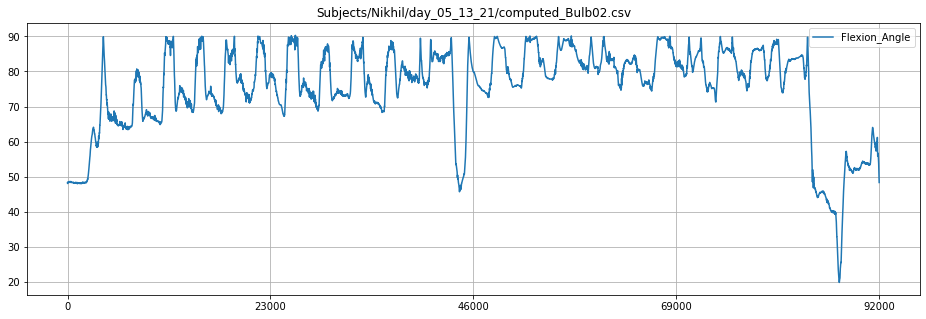

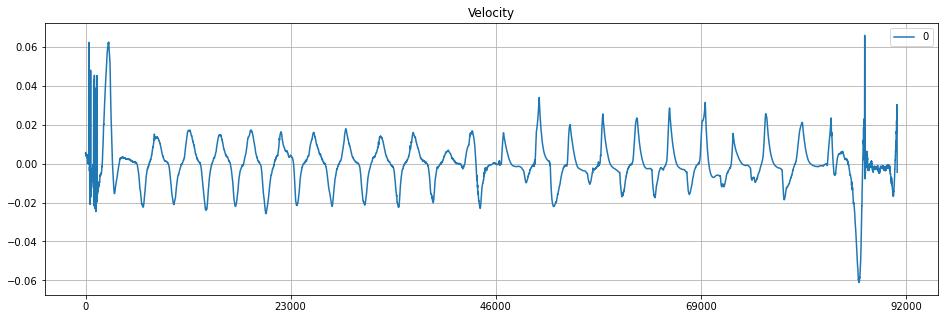

In [33]:
file = 'Subjects/Nikhil/day_05_13_21/computed_Bulb02.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Flexion_Angle'] # 'Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle'
df = pd.read_csv(file,index_col=0)
df[angle_lables].plot(figsize=(16,5),title=file,grid=True,xticks=np.linspace(0,len(df),5))

arr = np.diff([0]+list(df['Pronation_Angle']))
# arr = arr/df.index
b,a = signal.butter(1, 1,fs=2000)
arr = signal.lfilter(b, a,arr)
pd.DataFrame(arr[1000:]).plot(figsize=(16,5),title='Velocity',grid=True,xticks=np.linspace(0,len(df),5))

## Prep Data

In [34]:
window = 250

In [35]:
X, y = prep_data_velocity(df,window,interval=10,Normalize=False,rms=False,angle_label ='Pronation_Angle')
X.shape

(9175, 250, 8)

In [40]:
files = []
subjects = ['Fazil/day_04_24_21','Nikhil/day_05_13_21'] #'Fazil/day_04_14_21'
for subj in subjects:
    path = 'Subjects/'+subj
    # trial_names = ['Bulb','Hammer'] # 'Bulb','Hammer' ,'Cup','Screw'
    trial_names = ['Bulb','Hammer' ,'Cup','Screw'] #,
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                files.append(path+'/computed_'+exp+'.csv')
            else:
                files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Fazil/day_04_24_21/computed_Bulb.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Cup.csv',
 'Subjec

In [41]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0))

In [42]:
files_df = filter_df(files_df)

In [43]:
X, y = multiple_prep_data_velocity(files_df,250,interval=10,Normalize=False,rms=False,angle_label ='Pronation_Angle')
X.shape

(151800, 250, 8)

## Time Window Normalize

In [44]:
X_mean = np.zeros(X[0].shape)
for x in X:
    X_mean = X_mean + x
X_mean = X_mean/X.shape[0]
X_std = np.sqrt(variance(X))
np.save('mean_std',np.array([X_mean,X_std]))

In [45]:
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

## Test Train Split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(121440, 250, 8)
(30360, 250, 8)
(121440, 1)
(30360, 1)


# Neural Network Regression

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
n_outputs = 1

In [48]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
# model.add(Dense(64,activation='relu'))
model.add(Dense(n_outputs))

model.compile(loss='mse', optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 248, 64)           1600      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 246, 64)           12352     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 244, 64)           12352     
_________________________________________________________________
flatten_3 (Flatten)          (None, 15616)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 15617     
Total params: 41,921
Trainable params: 41,921
Non-trainable params: 0
_________________________________________________________________


In [49]:
cnn_history=model.fit(X_train,y_train,epochs = 200,batch_size = 2000,validation_data = (X_test,y_test) )

Epoch 1/200
61/61 [==============================] - 5s 79ms/step - loss: 0.0739 - root_mean_squared_error: 0.2719 - val_loss: 6.7544e-04 - val_root_mean_squared_error: 0.0260: 0.27
Epoch 2/200
61/61 [==============================] - 5s 76ms/step - loss: 5.3196e-04 - root_mean_squared_error: 0.0231 - val_loss: 3.9524e-04 - val_root_mean_squared_error: 0.0199oss: 6.2615e-04 - root_mean_squared_error: 0. - ETA: 2s - loss: 6.0932e-04 - root_mean_squared_error: 0.02 - ETA: 2s - loss: 6.0283e-04 - r
Epoch 3/200
61/61 [==============================] - 5s 76ms/step - loss: 3.3872e-04 - root_mean_squared_error: 0.0184 - val_loss: 2.8230e-04 - val_root_mean_squared_error: 0.0168
Epoch 4/200
61/61 [==============================] - 5s 76ms/step - loss: 2.5062e-04 - root_mean_squared_error: 0.0158 - val_loss: 2.1745e-04 - val_root_mean_squared_error: 0.0147 loss: 2.6900e-04 - root - ETA: 0s - loss: 2.5611e-04 - root_mean_squared_e
Epoch 5/200
61/61 [==============================] - 5s 77ms/ste

61/61 [==============================] - 5s 88ms/step - loss: 1.2134e-04 - root_mean_squared_error: 0.0110 - val_loss: 1.2125e-04 - val_root_mean_squared_error: 0.0110
Epoch 43/200
61/61 [==============================] - 5s 86ms/step - loss: 1.2130e-04 - root_mean_squared_error: 0.0110 - val_loss: 1.2134e-04 - val_root_mean_squared_error: 0.0110
Epoch 44/200
61/61 [==============================] - 5s 90ms/step - loss: 1.2115e-04 - root_mean_squared_error: 0.0110 - val_loss: 1.2108e-04 - val_root_mean_squared_error: 0.0110
Epoch 45/200
61/61 [==============================] - 6s 91ms/step - loss: 1.2115e-04 - root_mean_squared_error: 0.0110 - val_loss: 1.2099e-04 - val_root_mean_squared_error: 0.0110
Epoch 46/200
61/61 [==============================] - 6s 90ms/step - loss: 1.2091e-04 - root_mean_squared_error: 0.0110 - val_loss: 1.2099e-04 - val_root_mean_squared_error: 0.0110
Epoch 47/200
61/61 [==============================] - 6s 90ms/step - loss: 1.2086e-04 - root_mean_squared_er

61/61 [==============================] - 6s 102ms/step - loss: 1.1816e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.1764e-04 - val_root_mean_squared_error: 0.0108
Epoch 85/200
61/61 [==============================] - 6s 95ms/step - loss: 1.1778e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.1743e-04 - val_root_mean_squared_error: 0.0108
Epoch 86/200
61/61 [==============================] - 6s 96ms/step - loss: 1.1775e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.1746e-04 - val_root_mean_squared_error: 0.0108loss: 1.1711e-04 - root_mean_squared_er
Epoch 87/200
61/61 [==============================] - 6s 95ms/step - loss: 1.1809e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.2103e-04 - val_root_mean_squared_error: 0.0110
Epoch 88/200
61/61 [==============================] - 6s 95ms/step - loss: 1.1803e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.1717e-04 - val_root_mean_squared_error: 0.0108
Epoch 89/200
61/61 [==============================] - 6s 95ms/step -

61/61 [==============================] - 6s 99ms/step - loss: 1.0790e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.0800e-04 - val_root_mean_squared_error: 0.0104loss: 1.1102e-04 - root_mean_squared_error: 0 - ETA: 4s - loss: 1.1227e-04 - root_mean_squared_error: 0 - ETA: 3s - loss: 1.13
Epoch 125/200
61/61 [==============================] - 6s 98ms/step - loss: 1.0732e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.0769e-04 - val_root_mean_squared_error: 0.0104
Epoch 126/200
61/61 [==============================] - 6s 98ms/step - loss: 1.0811e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.0781e-04 - val_root_mean_squared_error: 0.0104
Epoch 127/200
61/61 [==============================] - 6s 97ms/step - loss: 1.0677e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.0663e-04 - val_root_mean_squared_error: 0.0103A: 0s - loss: 1.0776e-04 - root_mean_squared_erro
Epoch 128/200
61/61 [==============================] - 6s 98ms/step - loss: 1.0633e-04 - root_mean_squared_erro

61/61 [==============================] - 6s 99ms/step - loss: 9.4407e-05 - root_mean_squared_error: 0.0097 - val_loss: 9.4669e-05 - val_root_mean_squared_error: 0.0097A: 5s - loss: 8.8815e-05 -  - ETA: 2s - loss: 9.3829e-05 - root_me
Epoch 157/200
61/61 [==============================] - 6s 99ms/step - loss: 9.2809e-05 - root_mean_squared_error: 0.0096 - val_loss: 9.2819e-05 - val_root_mean_squared_error: 0.0096ss: 9.4858e-05 - root_mean_squar
Epoch 158/200
61/61 [==============================] - 6s 99ms/step - loss: 9.2676e-05 - root_mean_squared_error: 0.0096 - val_loss: 9.2663e-05 - val_root_mean_squared_error: 0.0096: 9.2385e-05 - root_mean_squared_error: 0. - ETA: 1s - loss: 9.2992e-05 - root_mean_squared_ - ETA: 0s - loss: 9.2693e-05 - root_mean_squared_error: 0.0
Epoch 159/200
61/61 [==============================] - 6s 100ms/step - loss: 9.1498e-05 - root_mean_squared_error: 0.0096 - val_loss: 9.3664e-05 - val_root_mean_squared_error: 0.0097
Epoch 160/200
61/61 [==============

61/61 [==============================] - 6s 100ms/step - loss: 5.0847e-05 - root_mean_squared_error: 0.0071 - val_loss: 5.4412e-05 - val_root_mean_squared_error: 0.00743s - loss: 5.0873e-05
Epoch 187/200
61/61 [==============================] - 6s 100ms/step - loss: 4.9313e-05 - root_mean_squared_error: 0.0070 - val_loss: 5.1604e-05 - val_root_mean_squared_error: 0.0072.0317e-05 - root_mean_squared_error: 0 - ETA: 3s - loss: 4.9537e-05 - root_me - ETA: 1s - loss: 4.9010e-05 - root_mean_squared_e
Epoch 188/200
61/61 [==============================] - 6s 100ms/step - loss: 4.7873e-05 - root_mean_squared_error: 0.0069 - val_loss: 5.2603e-05 - val_root_mean_squared_error: 0.0073s - loss: 4.8159e-05 - root_mean_squ - ETA: 0s - loss: 4.7895e-05 - root_mean_squared_er
Epoch 189/200
61/61 [==============================] - 6s 100ms/step - loss: 5.0659e-05 - root_mean_squared_error: 0.0071 - val_loss: 5.1827e-05 - val_root_mean_squared_error: 0.00724e-05 - root_mean_squared - ETA: 0s - loss: 5.

In [50]:
model.save('models/prosup_velocity_model_{}.hdf5'.format(window))

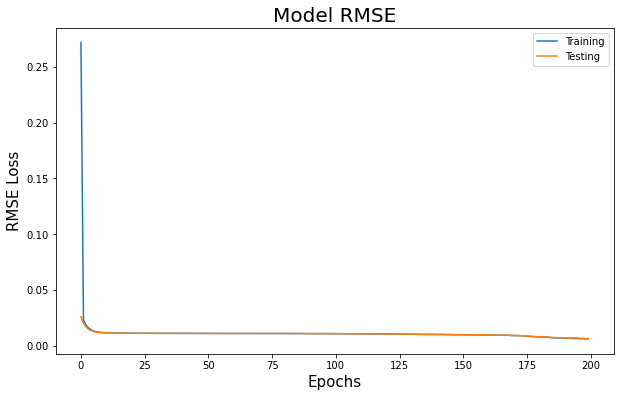

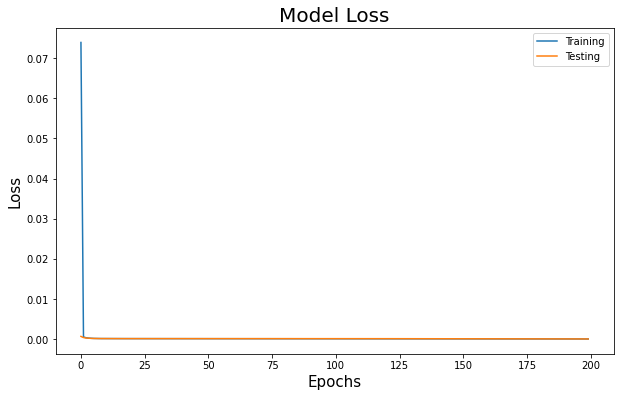

In [51]:
score = model.evaluate(X_test,y_test,verbose=0)
plot_model(cnn_history,score)

In [52]:
import matplotlib.pyplot as plt
def plot_model(history,score):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['root_mean_squared_error'][1:])
    plt.plot(history.history['val_root_mean_squared_error'][1:])
    plt.title('Model RMSE',size=20)
    plt.ylabel('RMSE Loss',size=15)
    plt.xlabel('Epochs', size=15)
    plt.legend(['Training', 'Testing'], loc='best')
    plt.show()
    
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss',size=20)
    plt.ylabel('Loss',size=15)
    plt.xlabel('Epochs',size=15)
    plt.legend(['Training', 'Testing'], loc='best')
    plt.show()

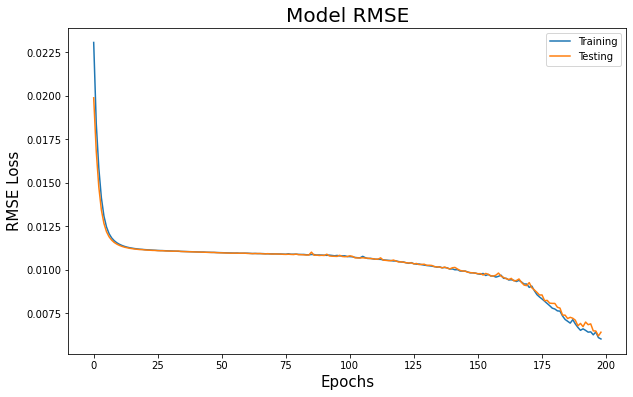

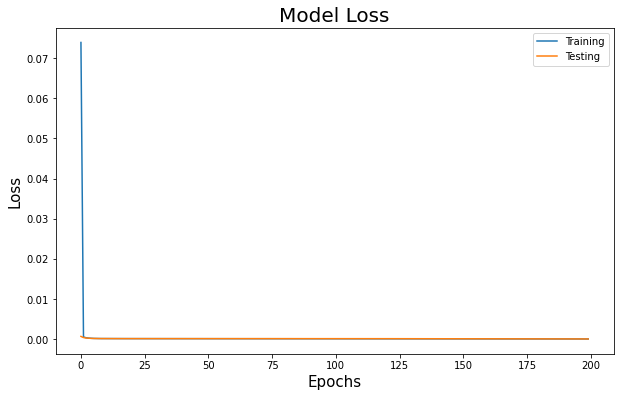

In [53]:
plot_model(cnn_history,score)